# Libraries

In [8]:
# %cd /users/keimy/git/JOIR_age

# !pip install torch==1.9.0 torchvision==0.10.0 numpy==1.22.1 pillow==9.0.0 tqdm==4.62.3 ipywidgets==8.0.2 timm==0.5.4
# !pip install pandas
# !pip install matplotlib


In [1]:
%cd /users/keimy/git/JOIR_age

# !pip install -r requirements_20221118.txt
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn

# # pytorchをダウンロードし直す
# !pip uninstall torch torchvision torchaudio -y
# !pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu

/Users/keimy/git/JOIR_age


In [2]:
import numpy as np
import pandas as pd

import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import timm

from PIL import Image
from tqdm.notebook import tqdm

# 乱数固定化の定義
def torch_seed(seed=1):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True


# Loading model

In [3]:
torch.backends.mps.is_available()

True

In [7]:
# モデル枠組み読み込み
model = timm.create_model(model_name='swin_base_patch4_window12_384', num_classes=1, pretrained=False)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# 学習済みモデル読み込み
model_path = 'params/model_20220903.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
# model.load_state_dict(torch.load(model_path))


/var/folders/lm/x817mz9j3dd69gvsjyjmyhcr0000gn/T/ipykernel_28960/3256558213.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

<All keys matched successfully>

# Inference (sample images)

In [8]:
import glob

# img_list = ['test1.jpg', 'test2.jpg']
img_list = glob.glob('datasets/figures/*.jpg')

# imageNetに合わせた画像の正規化
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# transformの定義
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
])

# Datasetクラスの作成
class Dataset(data.Dataset):
    def __init__(self, img_list, transform=None):
        self.img_list = img_list
        self.transform = transform
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        img_path = self.img_list[index]
        img = Image.open(img_path)
        img = self.transform(img)   
        return img

# Datasetの作成
dataset = Dataset(
    img_list=img_list, transform=transform
)

# Dataloaderの作成
# batch sizeはGPU(CPU)性能に応じて適宜変更して下さい
loader = data.DataLoader(
    dataset, batch_size=1, shuffle=False
)

# 乱数固定化
torch_seed()

# 年齢予測
pred_r = []

model.eval()
with torch.no_grad():
    for inputs in tqdm(loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        pred_r.append(outputs.data.cpu().numpy())
        
pred = np.concatenate(pred_r)

# 結果出力
print(pred)

  0%|          | 0/2 [00:00<?, ?it/s]

[[49.743153]
 [39.084404]]


# Inference (private images)

1000枚で2分くらい。CPUで。

In [9]:
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import pandas as pd


# 画像の正規化：ImageNetの平均と標準偏差
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# transformの定義（リサイズ + 正規化）
transform = transforms.Compose([
    transforms.ToPILImage(),  # numpy -> PIL.Image
    transforms.Resize((384, 384)),  # 画像サイズをモデルに合わせてリサイズ
    transforms.ToTensor(),  # PIL.Image -> Tensor
    transforms.Normalize(mean, std),  # 正規化
])

data = np.load("datasets/mini_fundus_images.npy" , allow_pickle=True)
id_list = data["ID"]
laterality_list = data["laterality"]
image_list = data["image"]


pred_list = []
model.eval()
for img in tqdm(image_list):
    img = transform(img)
    # バッチ次元を追加し、デバイスに転送
    img = img.unsqueeze(0).to(device)
    output = model(img)
    pred_list.append(float(output.item()))


df = pd.DataFrame({
    "ID": id_list,
    "laterality": laterality_list,
    "pred_age": pred_list
})

df.to_csv("outputs/pred_age.csv", index=False)
df.head()

 13%|█▎        | 129/1000 [00:14<01:41,  8.61it/s]


KeyboardInterrupt: 

leagcy

In [ ]:
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# 画像データに対する正規化
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# transformの定義（リサイズ + 正規化）
transform = transforms.Compose([
    transforms.ToPILImage(),  # numpy -> PIL.Image
    transforms.Resize((384, 384)),  # モデルに合わせてリサイズ
    transforms.ToTensor(),  # PIL.Image -> Tensor
    transforms.Normalize(mean, std),  # 正規化
])

# データ読み込み
data = np.load("datasets/mini_fundus_images.npy", allow_pickle=True)
image_list = data["image"]

# 画像をすべて変換
transformed_images = torch.stack([transform(img) for img in tqdm(image_list)])  # shape: (N, C, H, W)

# バッチ処理
batch_size = 32  # 適切なバッチサイズを設定
loader = torch.utils.data.DataLoader(transformed_images, batch_size=batch_size, shuffle=False)

# 推論
pred_list = []
model.eval()
with torch.no_grad():
    for batch in tqdm(loader):
        batch = batch.to(device)
        outputs = model(batch)
        pred_list.extend(outputs.squeeze().cpu().tolist())  # バッチ内の結果をリストに追加

print(pred_list)


# Visualize performance

In [22]:
%cd /users/keimy/git/Fundus2Age

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.weight'] = 'bold'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.titlesize'] = 15
# matplotlib.rcParams['font.style'] = 'italic'

def count_samples(df):
    n_kensa = len(df)
    n_eye = df[["ID", "laterality"]].drop_duplicates().shape[0]
    n_patient = df["ID"].nunique()
    return n_kensa, n_eye, n_patient

/Users/keimy/git/Fundus2Age


In [12]:
df_train = pd.read_csv("outputs/kenshin_train.csv")
df_test = pd.read_csv("outputs/kenshin_test.csv")
df_joir = pd.read_csv("outputs/pred_age_joir.csv")

count_samples(df_train), count_samples(df_test), count_samples(df_joir)

/var/folders/lm/x817mz9j3dd69gvsjyjmyhcr0000gn/T/ipykernel_25179/2229274875.py:1: DtypeWarning: Columns (36,170) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("outputs/kenshin_train.csv")
/var/folders/lm/x817mz9j3dd69gvsjyjmyhcr0000gn/T/ipykernel_25179/2229274875.py:2: DtypeWarning: Columns (35,36,170) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv("outputs/kenshin_test.csv")


((30686, 30686, 19349), (9673, 9673, 8768), (1000, 925, 463))

In [14]:
df_joir.head()

,ID,laterality,pred_age
0,20150422001,R,64.590858
1,20150422001,L,58.342815
2,20150511045,R,72.661087
3,20150511045,L,74.787987
4,20150709001,R,66.480438


In [17]:
# df_trainとdf_testではID, laterality, ageだけ残す
cols_keep = ["ID", "laterality", "age"]
df_train = df_train[cols_keep]
df_test = df_test[cols_keep]

# df_trainとdf_testを連結
df_kenshin = pd.concat([df_train, df_test], axis=0)
count_samples(df_kenshin)

(40359, 40359, 22491)

In [20]:
# df_joirとdf_kenshinを結合　IDとlateralityで
df = pd.merge(df_joir, df_kenshin, on=["ID", "laterality"], how="inner")

count_samples(df)

(456, 448, 272)

In [25]:

def plot_scatter(y_true, y_pred, target_name=None, save_path=None):
    offset = 3

    if target_name == "MD_slope":
        min_, max_ = -2, 0
    elif target_name == "VFI_slope":
        min_, max_ = -4, 0
    else:        
        min_ = min(y_true.min(), y_pred.min())
        max_ = max(y_true.max(), y_pred.max())

    plt.figure(figsize= (3, 3))
    plt.gca().set_aspect('equal', adjustable='box')

    plt.scatter(y_pred, y_true, marker=".", color="blue", s=10)

    plt.plot(
        [max_+offset, min_-offset],
        [max_+offset, min_-offset],
        color="darkorange",
        lw = 1,
        linestyle="dashed", 
        )
    
    plt.grid(alpha = 0.3)
    plt.xlim(min_-offset, max_+offset)
    plt.ylim(min_-offset, max_+offset)

    plt.title(f"{target_name}", fontsize=15)
    plt.xlabel(f"Predicted")
    plt.ylabel(f"True")
    # plt.legend(loc="lower right")

    # plt.tight_layout()
    plt.subplots_adjust(left=0.27, right=0.9, top=0.95, bottom=0.1)
    plt.savefig(f"{save_path}/{target_name}_scatter.pdf", transparent=True)

MAE: 5.99
MSE: 85.64
RMSE: 9.25


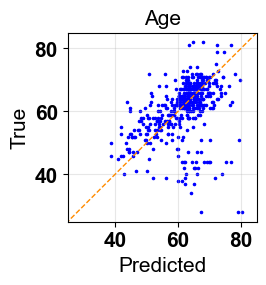

In [26]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

true_ages = df["age"].values
pred_ages = df["pred_age"].values

true_ages, pred_ages = np.array(true_ages), np.array(pred_ages)

mae = mean_absolute_error(true_ages, pred_ages)
mse = mean_squared_error(true_ages, pred_ages)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

plot_scatter(true_ages, pred_ages, target_name="Age", save_path="figures")